In [1]:
import os

import numpy as np
from PIL import Image as ImagePil
import matplotlib.pyplot as plt

from irreg.io import read_spimage
from irreg.representations import emsc_b, linear_YCbCr
from irreg.normalizations import standard_scaler, min_max_scaler
from irreg.utils.spectra import SpectraStatistics, Spectra
from irreg.utils.image import Spimage
from irreg.registration.landmark_based_registrator import LandmarkBasedRegistrator
from irreg.registration.sitk_registrator_from_json import SitkRegistratorFromJson, load_and_validate_params

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
%matplotlib inline

By this example we will demonstrate how to register H&E image and FTIR image.

# Loading images

We will use cropped images of Colon tissue for simplisity

## IR image

In [3]:
ir_filename = os.path.join(os.getcwd(), '..', 'data', 'FTIR.h5')
spectral_cube, wavenumbers = read_spimage(ir_filename)

### Grayscale conversion

In [43]:
spectral_cube.shape

(256, 256, 1428)

In [4]:
ir_gray = emsc_b(spectral_cube, wavenumbers)

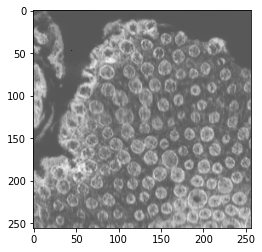

In [5]:
plt.imshow(ir_gray, cmap='gray')

In [6]:
ir_gray_im = ImagePil.fromarray(min_max_scaler(ir_gray, 0, 255).astype('uint8'))

In [7]:
ir_gray_im = ImagePil.fromarray(min_max_scaler(standard_scaler(ir_gray), 0, 255).astype('uint8'))

In [8]:
ir_gray_im.save(os.path.join(os.getcwd(), '..', 'data', 'ir_gray.png'), compress_level=9)

## H&E image

In [9]:
he_filename = os.path.join(os.getcwd(), '..', 'data', 'H&E.png')
he_image = ImagePil.open(he_filename)

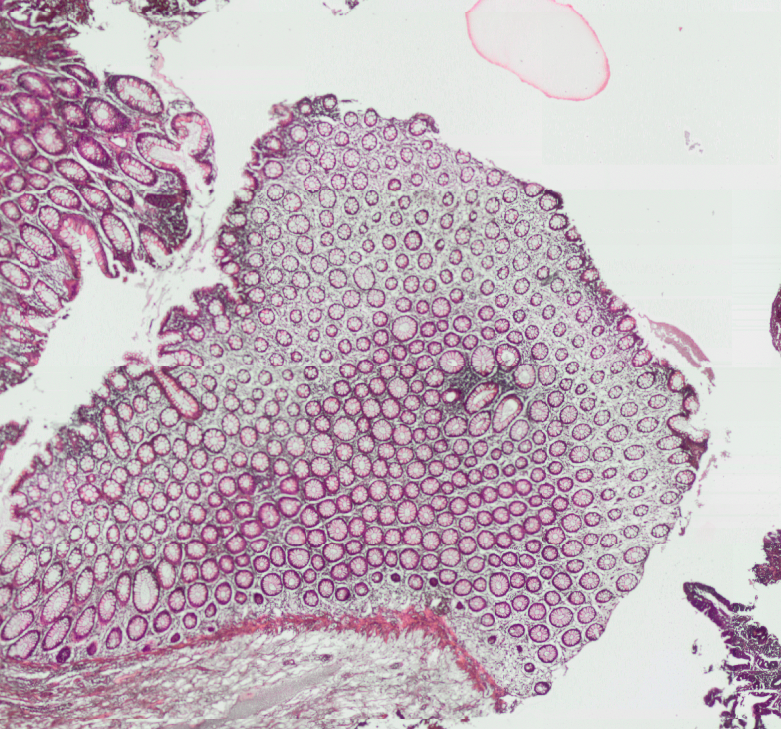

In [10]:
he_image

### Grayscale conversion

In [11]:
he_gray = linear_YCbCr(np.asarray(he_image, dtype='float'))

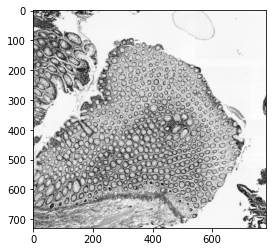

In [12]:
plt.imshow(he_gray, cmap='gray')

In [13]:
he_gray_im = ImagePil.fromarray(min_max_scaler(he_gray, 0, 255).astype('uint8'))

In [14]:
he_gray_im.save(os.path.join(os.getcwd(), '..', 'data', 'he_gray.png'), compress_level=9)

# Prepare images

Load images from file if necessarily. Transform images to float type ranged from 0 to 1. This step is optional

In [15]:
ir_gray =  min_max_scaler(standard_scaler(ir_gray), 0, 1) # standard scaling is optional

In [16]:
he_gray = 1 - min_max_scaler(he_gray, 0, 1) # to create consistent pallete we invert he gray image
                                             # such transformation does not affect on intensity based image registration (when MI metric is used)

# Manual registration

As the first registration step, we need to pre-register images by estimate the affine transformation using manually matched landmarks on H&E and IR images. In registration procedure, we define fixed image as IR image and moving image as H&E image.

We use Fiji to find such landmarks (https://imagej.net/Downloads). You need to install import/export macros to Fiji (see scripts/multiPointSet_export(import).ijm). Follow the manual at https://borda.github.io/dataset-histology-landmarks/ on how to create annotations using Fiji. 3-4 matched points should be enough to estimate the initial transformation.

As the result you get two csv files with coordinates on fixed and moving images. 

In [17]:
landmark_registrator = LandmarkBasedRegistrator(
    os.path.join(os.getcwd(), '..', 'data', 'landmarks', 'fixed_initial.csv'),
    os.path.join(os.getcwd(), '..', 'data', 'landmarks', 'moving_initial.csv'),
    ir_gray,
    he_gray,
    'test',
    os.path.join(os.getcwd(), '..', 'data', 'initial_results'),
)

In [18]:
landmark_registrator.register()

In [19]:
landmark_registrator.write_results()

In [20]:
print(landmark_registrator.final_transform)

itk::simple::Transform
 AffineTransform (00000211A37BD4C0)
   RTTI typeinfo:   class itk::AffineTransform<double,2>
   Reference Count: 1
   Modified Time: 702
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.1476 0.0623643 
     -0.0805823 1.11619 
   Offset: [170.502, 95.782]
   Center: [0, 0]
   Translation: [170.502, 95.782]
   Inverse: 
     0.867976 -0.0484959 
     0.0626627 0.892403 
   Singular: 0



In [36]:
landmark_registrator.evaluate(
    os.path.join(os.getcwd(), '..', 'data', 'landmarks', 'fixed_test.csv'),
    os.path.join(os.getcwd(), '..', 'data', 'landmarks', 'moving_test.csv'),
)

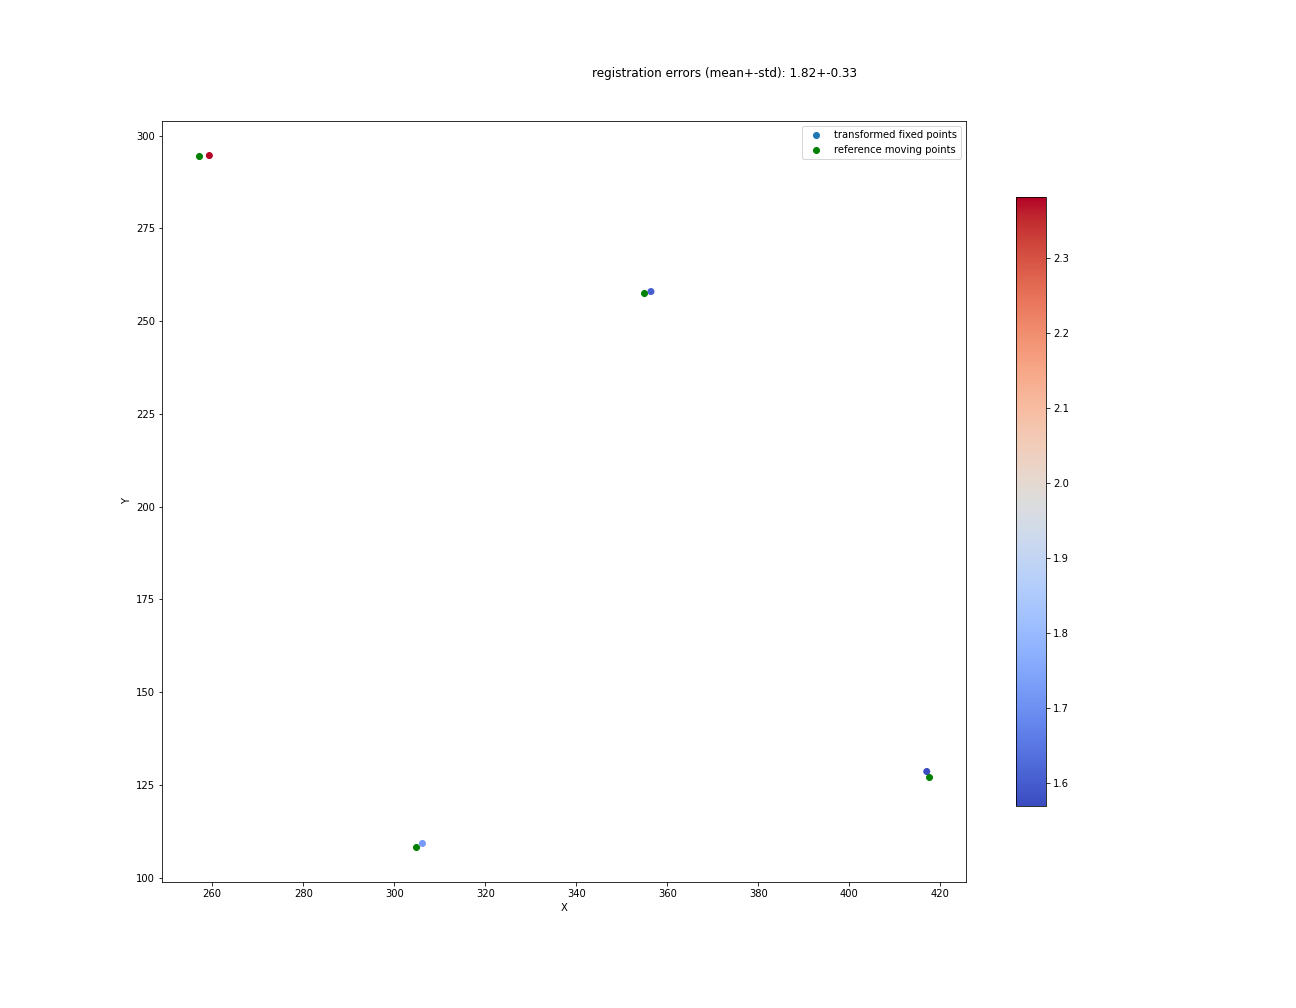

In [37]:
ImagePil.open(os.path.join(os.getcwd(), '..', 'data', 'initial_results', 'test_tre.png'))

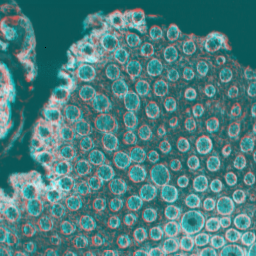

In [22]:
ImagePil.open(os.path.join(os.getcwd(), '..', 'data', 'initial_results', 'test_reg.png'))

# Automatic registration

Automatic image registration relies on SimpleITK library. The wrapper class SitkRegistratorFromJson (which is a little bit cumbersome) can load config which can be defined in json file. We didn't wrap everything from ITK/SimpleITK, thus if you need an additional configuration, please create PR.

## Affine registration

You can use predefined configs: 1_affine_cg.json and 2_affine_gd.json. You can also create and load your own config.

In [23]:
affine_params_filename = os.path.join(os.getcwd(), '..', 'irreg', 'registration', 'schemas', '1_affine_cg.json')
affine_params = load_and_validate_params(affine_params_filename)

In [24]:
affine_registrator = SitkRegistratorFromJson(
    affine_params,
    ir_gray,
    he_gray,
    'test',
    os.path.join(os.getcwd(), '..', 'data', 'affine_results'),
    os.path.join(os.getcwd(), '..', 'data', 'initial_results', 'test_transform.txt'),
)

In [25]:
affine_registrator.register()

In [26]:
affine_registrator.write_results()

In [27]:
print(affine_registrator.final_transform)

itk::simple::CompositeTransform
 CompositeTransform (00000211C155A4D0)
   RTTI typeinfo:   class itk::CompositeTransform<double,2>
   Reference Count: 1
   Modified Time: 196422
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   AffineTransform (00000211A3276010)
     RTTI typeinfo:   class itk::AffineTransform<double,2>
     Reference Count: 1
     Modified Time: 196409
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       1.1476 0.0623643 
       -0.0805823 1.11619 
     Offset: [170.502, 95.782]
     Center: [0, 0]
     Translation: [170.502, 95.782]
     Inverse: 
       0.867976 -0.0484959 
       0.0626627 0.892403 
     Singular: 0
   >>>>>>>>>
   AffineTransform (00000211A3276170)
     RTTI typeinfo:   class itk::AffineTransform<double,2>
     Reference Count: 2
     Modified Time: 196418
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       1.00808 -0.0

In [39]:
affine_registrator.evaluate(
    os.path.join(os.getcwd(), '..', 'data', 'landmarks', 'fixed_test.csv'),
    os.path.join(os.getcwd(), '..', 'data', 'landmarks', 'moving_test.csv'),
)

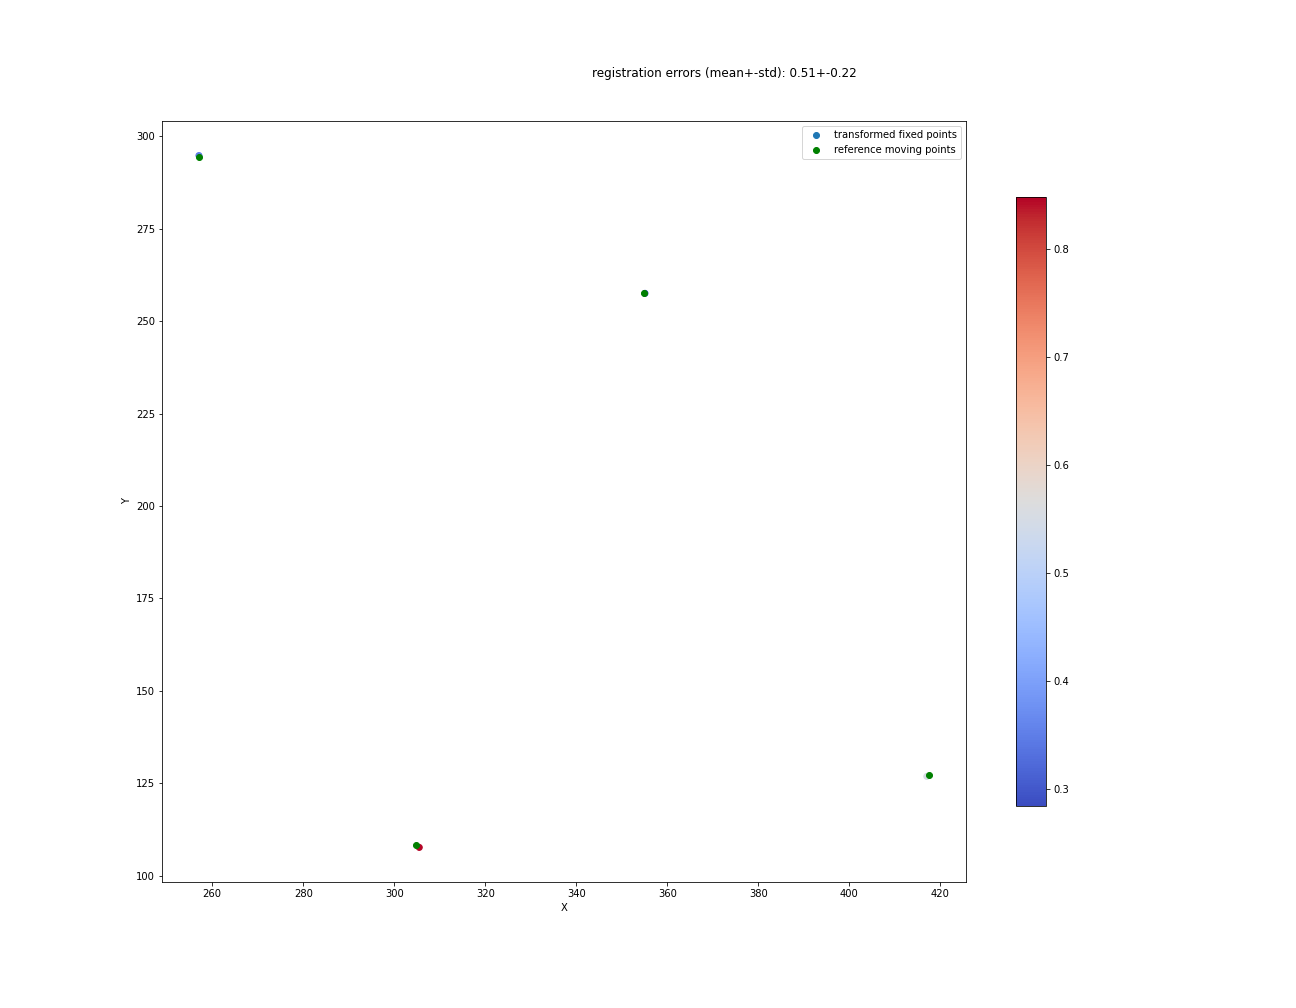

In [40]:
ImagePil.open(os.path.join(os.getcwd(), '..', 'data', 'affine_results', 'test_tre.png'))

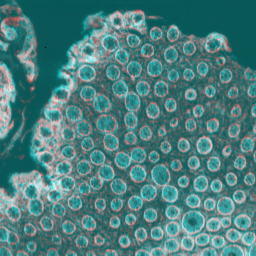

In [28]:
ImagePil.open(os.path.join(os.getcwd(), '..', 'data', 'affine_results', 'test_reg.png'))

In some cases, affine transformation can be good enough.

## BSpline registration

You can use predefined configs: 3_bspline_lbfgs2.json (simple) and 4_affine_gd.json (advanced). You can also create and load your own config.

In [29]:
bspline_params_filename = os.path.join(os.getcwd(), '..', 'irreg', 'registration', 'schemas', '3_bspline_lbfgs2.json')
bspline_params = load_and_validate_params(bspline_params_filename)

In [30]:
bspline_registrator = SitkRegistratorFromJson(
    bspline_params,
    ir_gray,
    he_gray,
    'test',
    os.path.join(os.getcwd(), '..', 'data', 'bspline_results'),
    os.path.join(os.getcwd(), '..', 'data', 'affine_results', 'test_transform.txt'),
)

In [31]:
bspline_registrator.register()

In [32]:
bspline_registrator.write_results()

In [41]:
bspline_registrator.evaluate(
    os.path.join(os.getcwd(), '..', 'data', 'landmarks', 'fixed_test.csv'),
    os.path.join(os.getcwd(), '..', 'data', 'landmarks', 'moving_test.csv'),
)

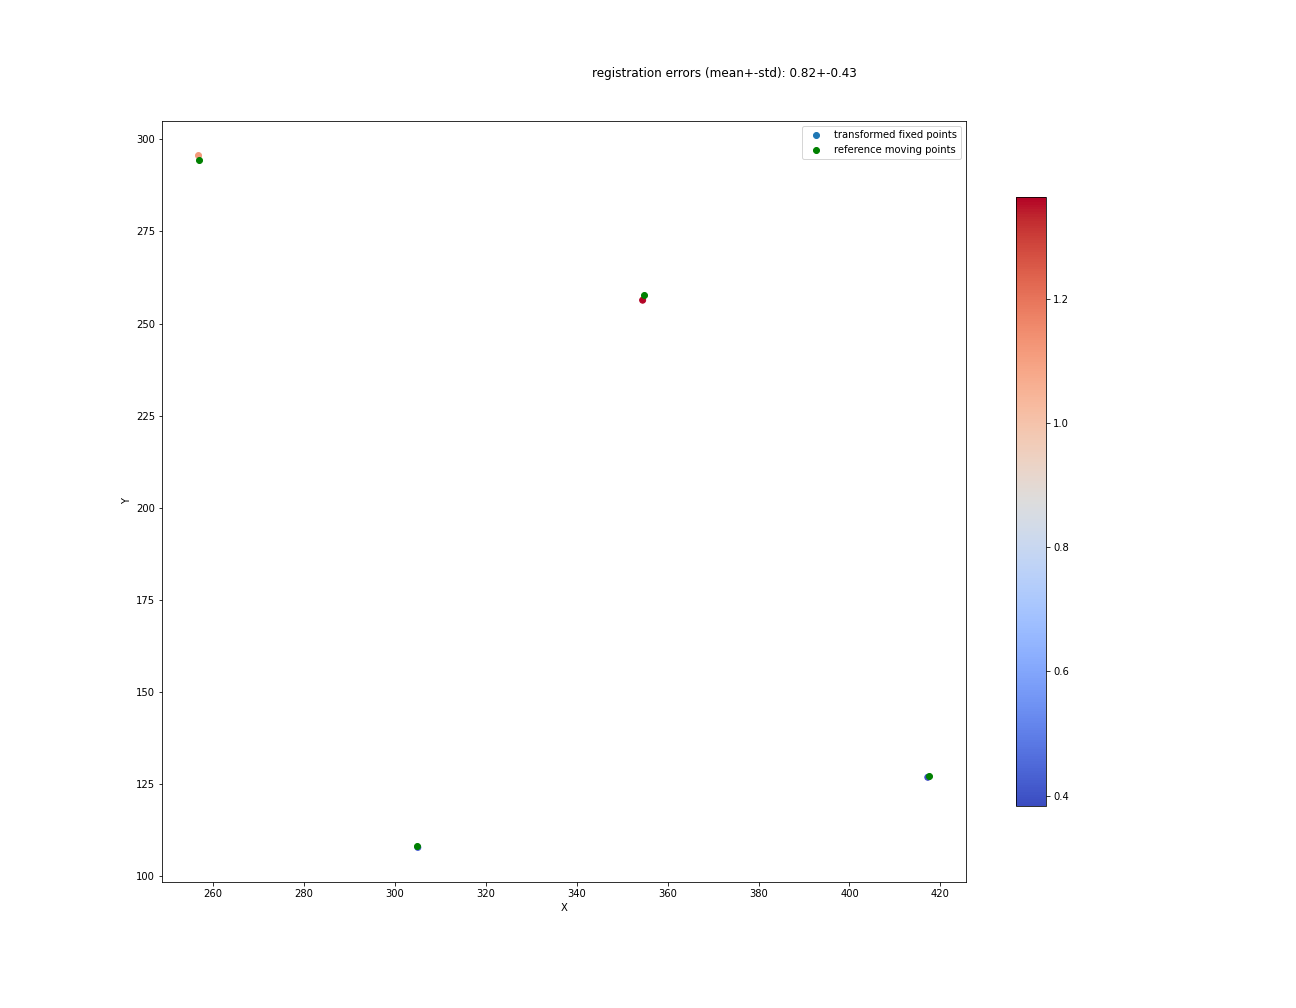

In [42]:
ImagePil.open(os.path.join(os.getcwd(), '..', 'data', 'bspline_results', 'test_tre.png'))

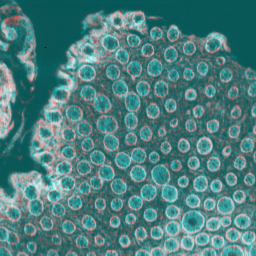

In [33]:
ImagePil.open(os.path.join(os.getcwd(), '..', 'data', 'bspline_results', 'test_reg.png'))